In [2]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

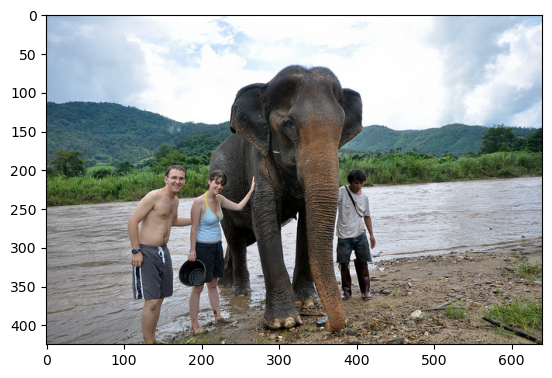

Label probs: [[26.7687   20.214054 19.25011  22.348814 17.527065 18.882036 19.086395
  19.25366  16.478971]]


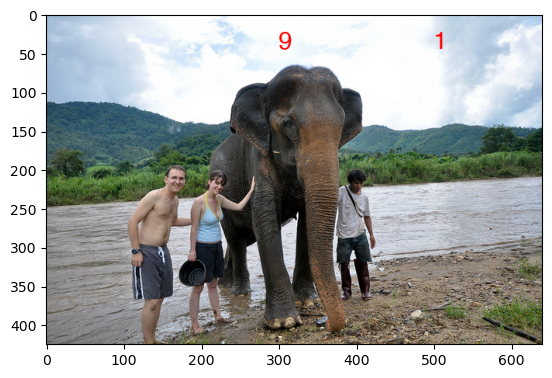

Label probs: [[27.167395 21.122458 19.715605 23.099926 17.957537 21.472172 21.407959
  21.101824 17.434599]]


In [40]:
from PIL import ImageDraw, ImageFont
from matplotlib import pyplot as plt

pil_img_ = Image.open("images/COCO_val2014_000000562207.jpg")
draw = ImageDraw.Draw(pil_img_)
font = ImageFont.truetype('Helvetica.ttc', size=32)
draw.text((300, 20), "9", fill="red", font=font)
draw.text((500, 20), "1", fill="red", font=font)
# pil_img = pil_img.convert('L')

opil_img = Image.open("images/COCO_val2014_000000562207.jpg")

for pil_img in [opil_img, pil_img_]:
    plt.imshow(pil_img)
    plt.show()
    image = preprocess(pil_img).unsqueeze(0).to(device)
    text = clip.tokenize(["elephant", "water", "human", "mud", "girl", "0", "1", "a", "dog"]).to(device)

    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)

        logits_per_image, logits_per_text = model(image, text)
        probs = logits_per_image.cpu().numpy()

    print("Label probs:", probs)

Label probs: [[26.7687   20.214054 19.25011  22.348814 16.478971 18.18951  18.10503
  18.10876  17.527065 18.014357 18.965897 22.561111]]


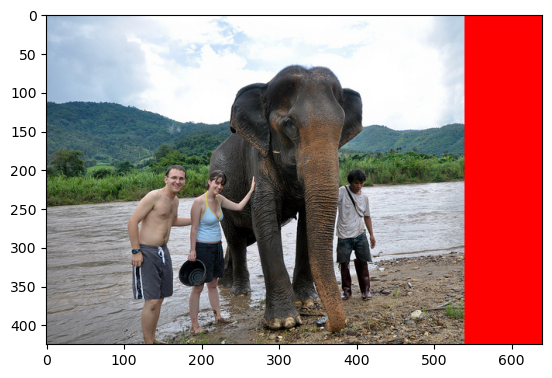

In [24]:
from PIL import ImageDraw, ImageFont
from matplotlib import pyplot as plt
import numpy as np

pil_img = Image.open("images/COCO_val2014_000000562207.jpg")
pil_img = np.array(pil_img)
pil_img[:, -100:] = (255, 0, 0)
pil_img = Image.fromarray(pil_img)
plt.imshow(pil_img)

image = preprocess(pil_img).unsqueeze(0).to(device)
text = clip.tokenize(["elephant", "water", "human", "mud", "dog", "red", "blue", "yellow", "girl", "queen", "king", "tusk"]).to(device)
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    # probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    probs = logits_per_image.cpu().numpy()

print("Label probs:", probs)

Label probs: [[27.167828 26.45932  22.363092 21.4848   22.889837 19.497301]
 [21.812456 20.404665 29.313047 22.683325 25.869602 19.909866]]


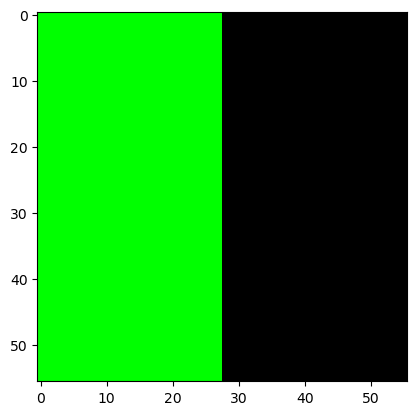

In [47]:
pil_img = Image.new("RGB", (56, 56))
pil_img = np.array(pil_img)
pil_img[:, :28] = (255, 0, 0)
pil_img[:, 28:] = (0, 0, 255)
pil_img = Image.fromarray(pil_img)
plt.imshow(pil_img)

pil_img2 = Image.new("RGB", (56, 56))
pil_img2 = np.array(pil_img2)
pil_img2[:, :28] = (0, 255, 0)
pil_img2 = Image.fromarray(pil_img2)
plt.imshow(pil_img2)
image = torch.stack([preprocess(_img) for _img in [pil_img, pil_img2]], dim=0).to(device)
text = clip.tokenize(["red", "blue", "green", "white", "black", "pink"]).to(device)
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

    logits_per_image, logits_per_text = model(image, text)
    # probs = logits_per_image.softmax(dim=-1).cpu().numpy()
    probs = logits_per_image.cpu().numpy()

print("Label probs:", probs)

Files already downloaded and verified


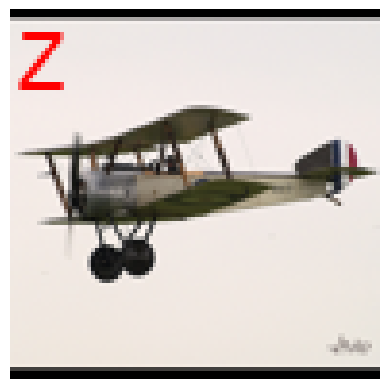

tensor([0., 1.])


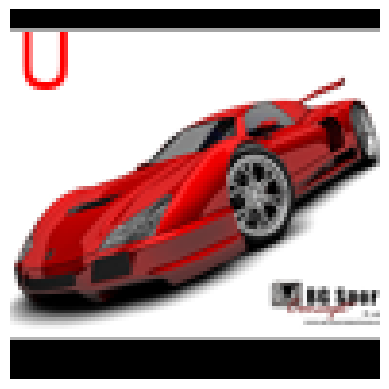

tensor([1., 0.])


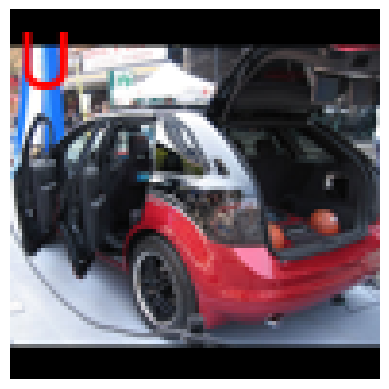

tensor([1., 0.])


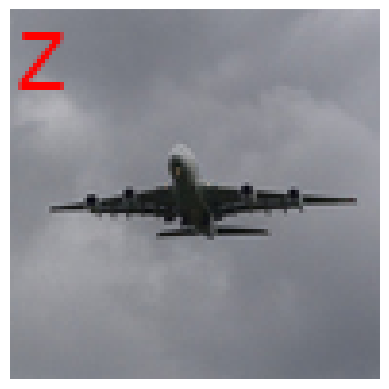

tensor([0., 1.])


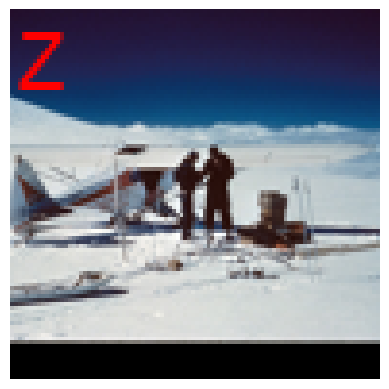

tensor([0., 1.])


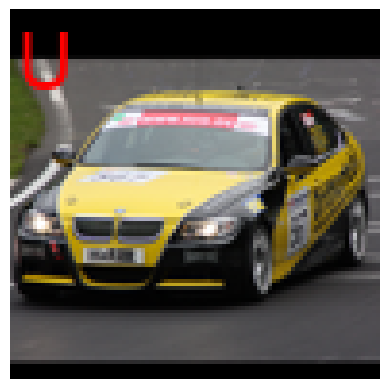

tensor([1., 0.])


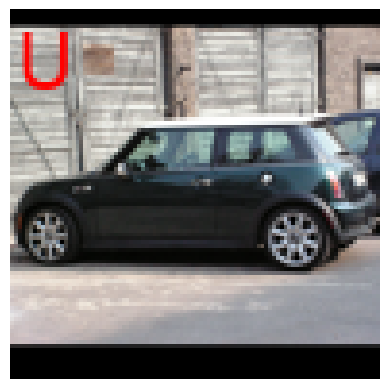

tensor([1., 0.])


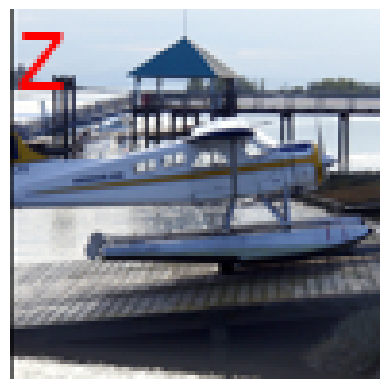

tensor([0., 1.])


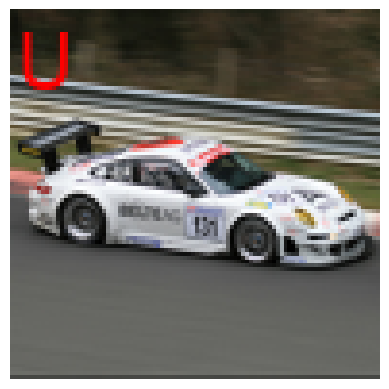

tensor([1., 0.])


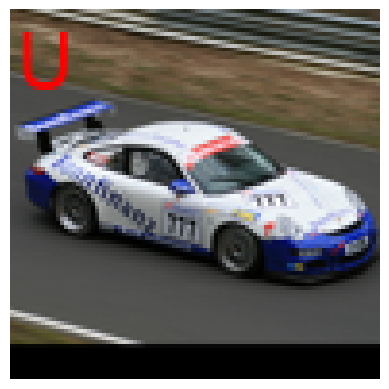

tensor([1., 0.])


In [2]:
from datasets.simple_tag_dataset import SimpleTag
from matplotlib import pyplot as plt
import torch

dat = SimpleTag(1.0)

# text = clip.tokenize(["car", "wheels", "windows", "plane", "wings", "fins", "dog"]).to(device)
for idx in range(20, 30):
    pil_img, y, g = dat.get_train_dataset()[idx] #.train_dataset[idx]
    plt.imshow(torch.permute(pil_img, [1, 2, 0]))
    plt.axis('off')
    if y==0:
        plt.savefig("plots/tag_0.pdf")
    else:
        plt.savefig("plots/tag_1.pdf")
    plt.show()
    print(g[-2:])
#     image = preprocess(pil_img).unsqueeze(0).to(device)
#     with torch.no_grad():
#         image_features = model.encode_image(image)
#         text_features = model.encode_text(text)

#         logits_per_image, logits_per_text = model(image, text)
#         probs = logits_per_image.softmax(dim=-1).cpu().numpy()

#     print("Label probs:", probs)

In [1]:
from datasets.simple_tag_dataset import SimpleTag
from matplotlib import pyplot as plt
import torch
import torch.utils.data  as data_utils
from torchvision import transforms as T
import clip
import tqdm
import numpy as np

device = "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
dat = SimpleTag(1.0)
dl = data_utils.DataLoader(dat.get_test_dataset(), batch_size=32, shuffle=False)

clip_concepts = clip.tokenize(dat.concept_names)

all_clip_sims, all_g = [], []
_pfn = T.ToPILImage()

for batch_x, batch_y, batch_g in tqdm.tqdm(dl, desc="Computing clip sims"):
    with torch.no_grad():
        clip_batch = torch.stack([clip_preprocess(_pfn(_x)) for _x in batch_x], dim=0)
        clip_logits_per_image, clip_logits_per_text = clip_model(clip_batch.to(device), clip_concepts.to(device))
    _clip_sims = clip_logits_per_image.detach().cpu() / 100
    all_clip_sims.append(_clip_sims)
    all_g.append(batch_g.cpu())

all_clip_sims = np.concatenate(all_clip_sims, axis=0)
all_g = np.concatenate(all_g, axis=0)

Files already downloaded and verified


Computing clip sims: 100%|██████████| 50/50 [00:27<00:00,  1.83it/s]


In [2]:
print(all_g.sum(axis=0), np.corrcoef(all_g[:, -1], all_clip_sims[:, -1])[0, 1], 
      np.corrcoef(all_g[:, -2], all_clip_sims[:, -2])[0, 1])
print(dat.concept_names, dat.tag_concept_names())

[800. 800. 800. 800. 800. 800. 800. 800. 800. 800. 800. 800.] 0.8028677701676376 0.5730743449887601
['wings', 'landing gear', 'sky', 'headlights', 'taillights', 'turn signals', 'windshield', 'windshield vipers', 'bumpers', 'wheels', 'U', 'Z'] ['U', 'Z']
